In [1]:
%pip install pandas numpy scikit-learn catboost optuna optuna-integration

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

В файле task.pdf содержится описание задания и данных. Требуется предсказать отток учителей с сервиса "Яндекс Учитель", основываясь на записях об их активности.

In [ ]:
data = pd.read_csv('data/train.csv')
data.head(5)

,month_churn,nid,report_date,v_0,v_1,v_10,v_100,v_101,v_102,v_103,...,v_91,v_92,v_93,v_94,v_95,v_96,v_97,v_98,v_99,week_churn
0,0,10363,2024-09-08,45,48,344,7,5,5,0,...,0,0,45,48,0,3,7,7,6,0
1,0,3303,2024-10-27,35,42,47,45,43,45,0,...,0,1,46,275,1,1,47,47,45,1
2,0,9732,2023-10-29,35,39,19,19,6,6,0,...,0,0,45,76,1,0,19,19,19,1
3,1,2934,2024-12-08,11,15,101,91,31,48,0,...,0,1,122,460,0,0,93,93,84,1
4,0,3251,2024-03-10,3,3,181,33,23,23,0,...,0,0,29,73,1,2,33,33,32,0


In [4]:
data['report_date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 248180 entries, 0 to 248179
Series name: report_date
Non-Null Count   Dtype 
--------------   ----- 
248180 non-null  object
dtypes: object(1)
memory usage: 1.9+ MB


Преобразуем report_date во временные признаки

In [5]:
def make_time_features(df, date_col='report_date'):
    """
    Создаёт новые временные признаки из даты и возвращает новый DataFrame.
    """
    df_copy = df.copy()

    out = pd.DataFrame(index=df_copy.index)
    out[date_col] = pd.to_datetime(df_copy[date_col], errors='coerce')

    out['year'] = out[date_col].dt.year
    out['month'] = out[date_col].dt.month
    out['day_of_month'] = out[date_col].dt.day
    out['day_of_year'] = out[date_col].dt.day_of_year
    out['day_of_week'] = out[date_col].dt.weekday  # 0=Пн, 6=Вс
    out['week_of_year'] = out[date_col].dt.isocalendar().week

    def get_season(month):
        if pd.isna(month):
            return np.nan
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Autumn'

    out['season'] = out[date_col].dt.month.apply(get_season)
    out['is_weekend'] = out[date_col].dt.weekday.isin([5, 6]).astype(int)

    return out

In [6]:
time_features = make_time_features(data, date_col='report_date')
time_features.head()

,report_date,year,month,day_of_month,day_of_year,day_of_week,week_of_year,season,is_weekend
0,2024-09-08,2024,9,8,252,6,36,Autumn,1
1,2024-10-27,2024,10,27,301,6,43,Autumn,1
2,2023-10-29,2023,10,29,302,6,43,Autumn,1
3,2024-12-08,2024,12,8,343,6,49,Winter,1
4,2024-03-10,2024,3,10,70,6,10,Spring,1


Добавим синус и косинус поверх месяцев и дней недели, чтобы модель учитывала цикличность.

In [7]:
def add_sin_cos(df, col, period):
    """
    Добавляет в DataFrame sin/cos преобразование от указанного признака.
    """
    df[col] = pd.to_numeric(df[col], errors='coerce')

    df[col+'_sin'] = np.sin(2 * np.pi * df[col] / period)
    df[col+'_cos'] = np.cos(2 * np.pi * df[col] / period)

add_sin_cos(time_features, 'day_of_week', 7)
add_sin_cos(time_features, 'month', 12)
add_sin_cos(time_features, 'week_of_year', 52)

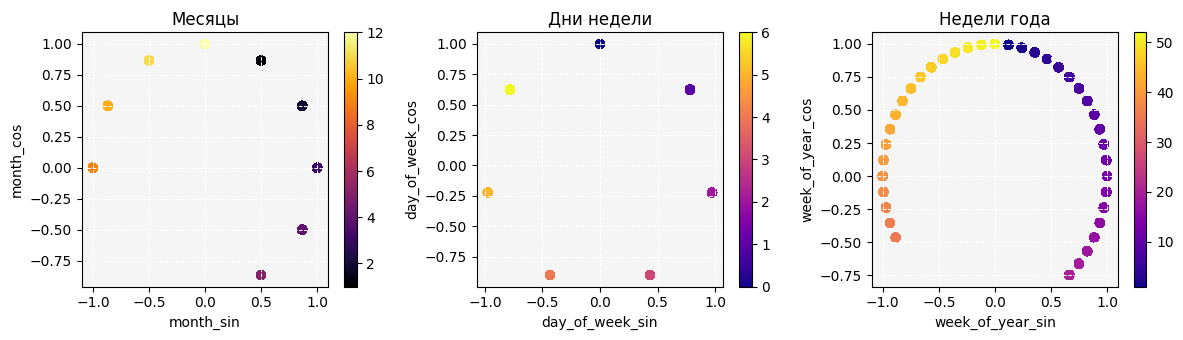

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
for ax in axes:
    ax.set_facecolor("whitesmoke")

sp_month = axes[0].scatter(
    time_features["month_sin"],
    time_features["month_cos"],
    c=time_features["month"],
    cmap="inferno"
)
axes[0].set(
    xlabel="month_sin",
    ylabel="month_cos",
    title="Месяцы"
)
axes[0].grid(True, color="white", linestyle="--", linewidth=0.7)
fig.colorbar(sp_month, ax=axes[0])

sp_day_of_week = axes[1].scatter(
    time_features["day_of_week_sin"],
    time_features["day_of_week_cos"],
    c=time_features["day_of_week"],
    cmap="plasma"
)
axes[1].set(
    xlabel="day_of_week_sin",
    ylabel="day_of_week_cos",
    title="Дни недели"
)
axes[1].grid(True, color="white", linestyle="--", linewidth=0.7)
fig.colorbar(sp_day_of_week, ax=axes[1])

sp_week_of_year = axes[2].scatter(
    time_features["week_of_year_sin"],
    time_features["week_of_year_cos"],
    c=time_features["week_of_year"],
    cmap="plasma"
)
axes[2].set(
    xlabel="week_of_year_sin",
    ylabel="week_of_year_cos",
    title="Недели года"
)
axes[2].grid(True, color="white", linestyle="--", linewidth=0.7)
fig.colorbar(sp_week_of_year, ax=axes[2])

plt.tight_layout()
plt.show()


На диаграмме для месяцев видно отсутсвие месяцев с 6 по 8, сравним со содержанием датафрейма.

In [9]:
sorted(time_features['month'].unique())

[np.int32(1),
 np.int32(2),
 np.int32(3),
 np.int32(4),
 np.int32(5),
 np.int32(9),
 np.int32(10),
 np.int32(11),
 np.int32(12)]

Применить B-spline или RBF преобразование для дня года будет проблематично, поскольку есть много записей 

In [10]:
from sklearn.preprocessing import SplineTransformer

spline = SplineTransformer(
    n_knots=12+2,
    degree=3,
    include_bias=False,
    extrapolation='periodic'
)

spline_features = spline.fit_transform(time_features[['day_of_year']])

spline_cols = [f'day_of_year_spline_{i+1}' for i in range(spline_features.shape[1])]
time_features[spline_cols] = spline_features

In [11]:
time_features.columns

Index(['report_date', 'year', 'month', 'day_of_month', 'day_of_year',
       'day_of_week', 'week_of_year', 'season', 'is_weekend',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'week_of_year_sin', 'week_of_year_cos', 'day_of_year_spline_1',
       'day_of_year_spline_2', 'day_of_year_spline_3', 'day_of_year_spline_4',
       'day_of_year_spline_5', 'day_of_year_spline_6', 'day_of_year_spline_7',
       'day_of_year_spline_8', 'day_of_year_spline_9', 'day_of_year_spline_10',
       'day_of_year_spline_11', 'day_of_year_spline_12'],
      dtype='object')

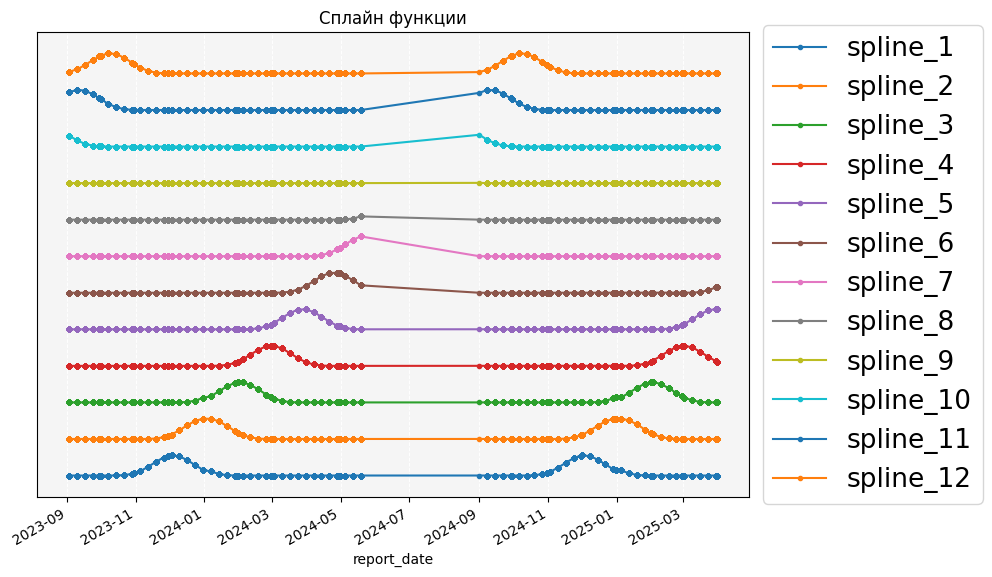

In [12]:
spline_plot = time_features[['report_date']+spline_cols].sort_values("report_date")

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor("whitesmoke")

spacing = 1.2  # расстояние между кривыми

for i, col in enumerate(spline_cols):
    y = spline_plot[col]
    ax.plot(spline_plot["report_date"], y+ i * spacing, marker = '.', linewidth=1.5, label=f'spline_{i+1}')

ax.set(
    xlabel="report_date",
    title="Сплайн функции"
)
ax.grid(True, color="white", linestyle="--", linewidth=0.7)
ax.set_yticks([])

ax.legend(fontsize=19, loc="center left", bbox_to_anchor=(1.0, 0.5)) 
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

На графиках получились скачки, так как летом записи не делались.

Работа с временными признаки закончена. Можно удалить ненужные колонки.

In [13]:
time_features.drop(columns = ['report_date', 'month', 'day_of_week', 'week_of_year', 'day_of_year'], axis = 1, inplace = True)
time_features.sample(10)

,year,day_of_month,season,is_weekend,day_of_week_sin,day_of_week_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos,...,day_of_year_spline_3,day_of_year_spline_4,day_of_year_spline_5,day_of_year_spline_6,day_of_year_spline_7,day_of_year_spline_8,day_of_year_spline_9,day_of_year_spline_10,day_of_year_spline_11,day_of_year_spline_12
164233,2024,1,Winter,1,-0.781831,0.62349,-2.449294e-16,1.000000,-0.464723,0.885456,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000086
92163,2024,17,Autumn,1,-0.781831,0.62349,-5.000000e-01,0.866025,-0.663123,0.748511,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.033279
153240,2024,10,Autumn,1,-0.781831,0.62349,-5.000000e-01,0.866025,-0.748511,0.663123,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.097577
23797,2024,21,Spring,1,-0.781831,0.62349,8.660254e-01,-0.500000,0.935016,-0.354605,...,0.000000,0.000527,0.249269,0.646694,0.103509,0.000000,0.0,0.0,0.000000,0.000000
3159,2024,14,Winter,1,-0.781831,0.62349,5.000000e-01,0.866025,0.239316,0.970942,...,0.364215,0.005674,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
96332,2023,29,Autumn,1,-0.781831,0.62349,-8.660254e-01,0.500000,-0.885456,0.464723,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.004715,0.351299
240815,2024,30,Spring,0,0.781831,0.62349,8.660254e-01,-0.500000,0.822984,-0.568065,...,0.000000,0.000000,0.092810,0.638023,0.268238,0.000929,0.0,0.0,0.000000,0.000000
149784,2025,23,Winter,1,-0.781831,0.62349,8.660254e-01,0.500000,0.822984,0.568065,...,0.305588,0.617754,0.074483,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
130108,2024,8,Winter,1,-0.781831,0.62349,-2.449294e-16,1.000000,-0.354605,0.935016,...,0.000844,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
218737,2023,17,Winter,1,-0.781831,0.62349,-2.449294e-16,1.000000,-0.239316,0.970942,...,0.016205,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [14]:
train = pd.concat([data.drop(columns = ['report_date'], axis = 1), time_features], axis = 1)

Добавим статистики признаков 'v_*', агреггированных по nid.

In [15]:
v_columns = data.drop(columns = ['report_date', 'nid', 'week_churn', 'month_churn']).columns.to_list()
v_stats = data.groupby(by = 'nid')[v_columns].agg(['mean', 'std','min','max', 'median'])
v_stats.columns = ['_'.join(col).strip() for col in v_stats.columns.values]
v_stats.sample(10)

,v_0_mean,v_0_std,v_0_min,v_0_max,v_0_median,v_1_mean,v_1_std,v_1_min,v_1_max,v_1_median,...,v_98_mean,v_98_std,v_98_min,v_98_max,v_98_median,v_99_mean,v_99_std,v_99_min,v_99_max,v_99_median
nid,,,,,,,,,,,,,,,,,,,,,
2777,7.000000,1.549193,4,8,7.5,10.166667,5.913262,4,21,8.5,...,10.833333,5.600595,3,18,12.0,7.333333,2.943920,3,11,8.0
486,18.413793,16.785447,3,73,11.0,30.448276,34.226750,3,124,15.0,...,28.482759,13.170911,7,51,24.0,25.137931,12.158842,2,46,24.0
6357,3.500000,0.707107,3,4,3.5,4.500000,0.707107,4,5,4.5,...,9.000000,0.000000,9,9,9.0,4.000000,0.000000,4,4,4.0
7743,129.614035,76.514414,4,293,130.0,319.701754,513.279650,4,3399,175.0,...,453.684211,155.831314,107,732,448.0,439.122807,155.229907,105,721,444.0
569,128.241935,67.224772,7,283,139.5,205.709677,188.728566,7,953,158.0,...,228.370968,97.493881,4,381,248.5,183.532258,79.116374,4,346,203.5
6067,8.200000,3.645393,3,14,8.5,13.700000,9.809859,3,36,10.5,...,54.700000,26.153606,6,88,59.5,39.400000,19.760792,3,64,43.5
9503,59.468085,29.863349,4,115,63.0,100.957447,109.184518,4,525,63.0,...,167.063830,66.512308,24,352,165.0,116.617021,52.791861,16,266,110.0
3027,27.285714,19.922469,6,59,28.0,81.714286,87.680698,6,241,62.0,...,44.142857,19.718254,19,64,55.0,40.571429,20.222571,18,61,52.0
2661,16.961538,10.875590,3,45,17.5,19.230769,14.854784,3,59,18.0,...,8.653846,4.979496,2,21,7.5,4.230769,4.169486,0,16,3.0


In [16]:
train = train.merge(v_stats, on='nid', how='left')

In [ ]:
test = pd.read_csv('data/test.csv')
test_tf = make_time_features(test)

add_sin_cos(test_tf, 'day_of_week', 7)
add_sin_cos(test_tf, 'month', 12)
add_sin_cos(test_tf, 'week_of_year', 52)

spline_features_test = spline.fit_transform(test_tf[['day_of_year']])
spline_cols_test = [f'day_of_year_spline_{i+1}' for i in range(spline_features_test.shape[1])]
test_tf[spline_cols_test] = spline_features_test

test_tf.drop(columns = ['report_date', 'month', 'day_of_week', 'week_of_year', 'day_of_year'], axis = 1, inplace = True)
test = pd.concat([test.drop(columns = ['report_date'], axis = 1), test_tf], axis = 1)
test = test.merge(v_stats, on='nid', how='left')

In [18]:
test.sample(10)

,nid,v_0,v_1,v_10,v_100,v_101,v_102,v_103,v_104,v_105,...,v_98_mean,v_98_std,v_98_min,v_98_max,v_98_median,v_99_mean,v_99_std,v_99_min,v_99_max,v_99_median
2075,2255,11,16,154,76,27,35,0,0,0,...,72.240000,33.057501,2.0,142.0,75.5,57.740000,29.897655,2.0,128.0,56.0
2682,571,38,40,37,37,10,10,0,0,0,...,91.888889,56.822486,24.0,205.0,83.0,54.296296,41.053263,6.0,138.0,41.0
9808,10004,79,161,717,281,51,101,0,0,0,...,138.086207,110.476366,5.0,353.0,72.0,74.189655,56.207153,5.0,173.0,46.0
4342,2924,61,105,13,13,4,5,0,0,0,...,12.800000,2.489980,9.0,16.0,13.0,11.800000,2.489980,8.0,15.0,12.0
20135,10910,48,59,430,192,96,83,0,0,0,...,156.050000,59.881925,11.0,241.0,165.5,137.216667,51.465668,9.0,218.0,146.0
25329,9106,26,26,507,260,142,195,0,0,0,...,207.935484,125.942853,3.0,402.0,205.5,169.516129,104.188156,0.0,339.0,162.0
7305,9392,16,56,73,56,17,29,0,0,0,...,43.571429,17.850052,4.0,71.0,48.0,34.107143,14.464104,4.0,56.0,37.0
8532,9905,38,45,297,177,68,112,0,0,0,...,299.030303,170.063062,29.0,697.0,241.5,197.803030,103.762038,16.0,430.0,152.0
1390,854,150,210,117,75,23,32,0,0,0,...,60.842105,23.561417,23.0,96.0,68.0,58.157895,22.171712,23.0,92.0,65.0
21666,2175,87,127,125,119,103,109,0,0,0,...,188.766667,128.624469,7.0,399.0,142.0,171.000000,119.191819,5.0,351.0,122.0


Разделим задачу на две: классификация по month_churn и классификация по week_churn. Используем CatBoost, в категориальные признаки подадим nid, поскольку модель должна отслеживать историю определенного учителя. Для начала попрубуем стандартные параметры.

In [23]:
from sklearn.model_selection import cross_val_score, KFold
from catboost import CatBoostClassifier

X = train.drop(columns = ['week_churn', 'month_churn'], axis = 1)
y_month = train[['month_churn']]
y_week = train[['week_churn']]

cbk_baseline = CatBoostClassifier(
    cat_features=['nid', 'season', 'is_weekend'], 
    verbose=100,  
    random_seed=100, 
    thread_count=-1, 
    iterations=350,
    eval_metric='AUC'
)

cv = KFold(n_splits=5, shuffle=True, random_state=100)

scores_month = cross_val_score(
    cbk_baseline, X, y_month, 
    cv=cv, 
    scoring='roc_auc', 
    n_jobs=-1
)

scores_week = cross_val_score(
    cbk_baseline, X, y_week, 
    cv=cv, 
    scoring='roc_auc', 
    n_jobs=-1
)

print(f"Mean ROC-AUC week_churn prediction: {scores_week.mean()}")
print(f"Mean ROC-AUC month_churn prediction: {scores_month.mean()}")

Learning rate set to 0.25835
Learning rate set to 0.25835
Learning rate set to 0.25835
Learning rate set to 0.25835
Learning rate set to 0.25835
0:	total: 1.92s	remaining: 11m 10s
0:	total: 1.9s	remaining: 11m 2s
0:	total: 1.8s	remaining: 10m 26s
0:	total: 1.58s	remaining: 9m 11s
0:	total: 1.77s	remaining: 10m 17s
100:	total: 3m 5s	remaining: 7m 36s
100:	total: 3m 5s	remaining: 7m 36s
100:	total: 3m 6s	remaining: 7m 38s
100:	total: 3m 6s	remaining: 7m 39s
100:	total: 3m 7s	remaining: 7m 41s
200:	total: 5m 55s	remaining: 4m 23s
200:	total: 5m 56s	remaining: 4m 24s
200:	total: 5m 58s	remaining: 4m 26s
200:	total: 6m	remaining: 4m 27s
200:	total: 6m 3s	remaining: 4m 29s
300:	total: 9m 3s	remaining: 1m 28s
300:	total: 9m 3s	remaining: 1m 28s
300:	total: 9m 4s	remaining: 1m 28s
300:	total: 9m 6s	remaining: 1m 28s
300:	total: 9m 9s	remaining: 1m 29s
349:	total: 10m 34s	remaining: 0us
349:	total: 10m 35s	remaining: 0us
349:	total: 10m 35s	remaining: 0us
349:	total: 10m 36s	remaining: 0us
349:

In [ ]:
cbk_baseline.fit(X, y_month)
month_pred = cbk_baseline.predict(test)

cbk_baseline.fit(X, y_week)
week_pred = cbk_baseline.predict(test)

submission = pd.DataFrame({
    "nid": test["nid"],
    "week_churn": week_pred,
    "month_churn": month_pred
})

submission.to_csv("submission/submission1.csv", index=False)

Learning rate set to 0.284177
0:	total: 373ms	remaining: 2m 10s
100:	total: 27.8s	remaining: 1m 8s
200:	total: 56.7s	remaining: 42s
300:	total: 1m 25s	remaining: 14s
349:	total: 1m 40s	remaining: 0us
Learning rate set to 0.284177
0:	total: 461ms	remaining: 2m 40s
100:	total: 33.9s	remaining: 1m 23s
200:	total: 1m 6s	remaining: 49.2s
300:	total: 1m 39s	remaining: 16.2s
349:	total: 1m 56s	remaining: 0us


In [76]:
for param, value in cbk_baseline.get_all_params().items():
    print(f"  {param}: {value}")

  nan_mode: Min
  eval_metric: AUC
  combinations_ctr: ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1']
  iterations: 350
  sampling_frequency: PerTree
  fold_permutation_block: 0
  leaf_estimation_method: Newton
  random_score_type: NormalWithModelSizeDecrease
  counter_calc_method: SkipTest
  grow_policy: SymmetricTree
  penalties_coefficient: 1
  boosting_type: Plain
  model_shrink_mode: Constant
  feature_border_type: GreedyLogSum
  ctr_leaf_count_limit: 18446744073709551615
  bayesian_matrix_reg: 0.10000000149011612
  one_hot_max_size: 2
  eval_fraction: 0
  force_unit_auto_pair_weights: False
  l2_leaf_reg: 3
  random_strength: 1
  rsm: 1
  boost_from_average: False
  max_ctr_complexity: 4
  model_size_reg: 0.5
  simple_ctr: ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0

Без подбора гиперпараметров удалось достичь 0.923 и 0.997 значений средних ROC-AUC для предсказания week_churn и month_churn соответсвтенно. Используем библиотеку Optuna и ее интеграцию для CatBoost.

In [ ]:
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from optuna.integration import CatBoostPruningCallback

import warnings
import logging

# Полностью отключаем все предупреждения
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.ERROR)

# Отключаем конкретные логгеры
logging.getLogger('optuna').setLevel(logging.ERROR)
logging.getLogger('catboost').setLevel(logging.ERROR)

def objective_week(trial: optuna.Trial) -> float:
    X = train.drop(columns = ['week_churn', 'month_churn'])
    y = train[['week_churn']].values.ravel()
    
    # Базовые параметры
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 6, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bernoulli', 'MVS', 'Bayesian']),
        'leaf_estimation_method': trial.suggest_categorical('leaf_estimation_method', ['Newton', 'Gradient']),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 3, 15),
        
        # Фиксированные параметры
        'cat_features' : ['nid', 'season', 'is_weekend'], 
        'verbose': False,
        'random_state': 100,
        'thread_count': -1,
        'eval_metric': 'AUC', 
        'iterations': 350,
    }

    # Условные параметры
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli" or param["bootstrap_type"] == "MVS":
        param['subsample'] = trial.suggest_float('subsample', 0.5, 1.0)
        pass
            
    # кросс-валидация
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=100)
    
    cv_scores = []
    
    for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
        train_x, valid_x = X.iloc[train_idx], X.iloc[valid_idx]
        train_y, valid_y = y[train_idx], y[valid_idx]
        
        model = CatBoostClassifier(**param)
        
        pruning_callback = CatBoostPruningCallback(trial, "AUC")
        
        model.fit(
            train_x,
            train_y,
            eval_set=[(valid_x, valid_y)],
            verbose=0,
            early_stopping_rounds=100,
            callbacks=[pruning_callback],
        )
        
        pruning_callback.check_pruned()
        
        # Предсказания для ROC-AUC
        preds_proba = model.predict_proba(valid_x)[:, 1]
        auc_score = roc_auc_score(valid_y, preds_proba)
        cv_scores.append(auc_score)
        
        # Прерывание trial если нужно
        if trial.should_prune():
            raise optuna.TrialPruned()

    # Возвращаем средний ROC-AUC по всем фолдам
    return np.mean(cv_scores)


if __name__ == "__main__":
    study_week = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), 
        direction="maximize"
    )
    study_week.optimize(objective_week, n_trials=30, show_progress_bar=True)

    print("Number of finished trials: {}".format(len(study_week.trials)))



  0%|          | 0/30 [00:00<?, ?it/s]

Number of finished trials: 30


In [58]:
print("Best trial:")
trial1_week = study_week.best_trial

print("  Value (ROC-AUC): {:.4f}".format(trial1_week.value))

print("  Params: ")
for key, value in trial1_week.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value (ROC-AUC): 0.9131
  Params: 
    objective: CrossEntropy
    learning_rate: 0.17904138840801778
    depth: 10
    l2_leaf_reg: 2.1015056462706747
    random_strength: 1.9064898525803036
    colsample_bylevel: 0.08164060718696657
    border_count: 180
    min_data_in_leaf: 53
    grow_policy: SymmetricTree
    bootstrap_type: Bernoulli
    leaf_estimation_method: Gradient
    leaf_estimation_iterations: 9
    subsample: 0.8220159317400763


In [ ]:
def objective_month(trial: optuna.Trial) -> float:
    X = train.drop(columns = ['week_churn', 'month_churn'])
    y = train[['month_churn']].values.ravel()
    
    # Базовые параметры
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 9, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bernoulli', 'MVS', 'Bayesian']),
        'leaf_estimation_method': trial.suggest_categorical('leaf_estimation_method', ['Newton', 'Gradient']),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 3, 15),
        
        # Фиксированные параметры
        'cat_features' : ['nid', 'season', 'is_weekend'], 
        'verbose': False,
        'random_state': 100,
        'thread_count': -1,
        'eval_metric': 'AUC', 
        'iterations': 350,
    }

    # Условные параметры
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli" or param["bootstrap_type"] == "MVS":
        param['subsample'] = trial.suggest_float('subsample', 0.5, 1.0)
        pass
            
    # кросс-валидация
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=100)
    cv_scores = []
    
    for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
        train_x, valid_x = X.iloc[train_idx], X.iloc[valid_idx]
        train_y, valid_y = y[train_idx], y[valid_idx]
        
        model = CatBoostClassifier(**param)
        
        pruning_callback = CatBoostPruningCallback(trial, "AUC")
        
        model.fit(
            train_x,
            train_y,
            eval_set=[(valid_x, valid_y)],
            verbose=0,
            early_stopping_rounds=100,
            callbacks=[pruning_callback],
        )
        
        pruning_callback.check_pruned()
        
        # Предсказания для ROC-AUC
        preds_proba = model.predict_proba(valid_x)[:, 1]
        auc_score = roc_auc_score(valid_y, preds_proba)
        cv_scores.append(auc_score)
        
        # Прерывание trial если нужно
        if trial.should_prune():
            raise optuna.TrialPruned()

    # Возвращаем средний ROC-AUC по всем фолдам
    return np.mean(cv_scores)


if __name__ == "__main__":
    study_month = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), 
        direction="maximize"
    )
    study_month.optimize(objective_month, n_trials=30, show_progress_bar=True)

    print("Number of finished trials: {}".format(len(study_month.trials)))



  0%|          | 0/30 [00:00<?, ?it/s]

Number of finished trials: 30


In [ ]:
print("Best trial:")
trial1_month = study_month.best_trial

print("  Value (ROC-AUC): {:.4f}".format(trial1_month.value))

print("  Params: ")
for key, value in trial1_month.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value (ROC-AUC): 0.9953
  Params: 
    objective: Logloss
    learning_rate: 0.2972676853414752
    depth: 11
    l2_leaf_reg: 3.2599225182365656
    random_strength: 6.551284248552081
    colsample_bylevel: 0.06366908996340805
    border_count: 169
    min_data_in_leaf: 49
    grow_policy: SymmetricTree
    bootstrap_type: MVS
    leaf_estimation_method: Newton
    leaf_estimation_iterations: 7
    subsample: 0.7769931480631598


In [ ]:
const_params = {'cat_features' : ['nid', 'season', 'is_weekend'], 
'verbose': 100,
'random_state': 100,
'thread_count': -1,
'eval_metric': 'AUC', 
'iterations': 500}

cbk_month = CatBoostClassifier(**trial1_month.params, **const_params)
cbk_week = CatBoostClassifier(**trial1_week.params, **const_params)

cbk_month.fit(X, y_month)
month_pred = cbk_month.predict(test)

cbk_week.fit(X, y_week)
week_pred = cbk_week.predict(test)

submission = pd.DataFrame({
    "nid": test["nid"],
    "week_churn": week_pred,
    "month_churn": month_pred
})

submission.to_csv("submission/submission2.csv", index=False)

0:	total: 183ms	remaining: 1m 31s
100:	total: 17.5s	remaining: 1m 8s
200:	total: 35.5s	remaining: 52.8s
300:	total: 53.8s	remaining: 35.6s
400:	total: 1m 11s	remaining: 17.8s
499:	total: 1m 30s	remaining: 0us
0:	total: 212ms	remaining: 1m 46s
100:	total: 19.7s	remaining: 1m 17s
200:	total: 39.3s	remaining: 58.5s
300:	total: 58.7s	remaining: 38.8s
400:	total: 1m 17s	remaining: 19.1s
499:	total: 1m 35s	remaining: 0us


Подбор гиперпараметров не дал прироста. Возможно что 30 итераций было недостаточно, или же оптимальными параметрами являются параметры по умолчанию и с большим числом итераций оптимизатор бы это подтвердил. ROC-AUC для полного предсказания submission1 составил 0.909989, для submussion2 -- 0.893150. 

Для улучшения результатов можно было бы применить другие стратегии обучения: подавать модели данные батчами, сгрупированными по nid или использовать TimeSeriesSplit.